<a href="https://colab.research.google.com/github/solcanalla/fiumark/blob/main/stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Modelo: Stacking

##Inicialización##

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
!git clone https://github.com/solcanalla/fiumark.git
%cd fiumark
!git pull origin main
import preprocessing as pp

fatal: destination path 'fiumark' already exists and is not an empty directory.
/content/fiumark
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/solcanalla/fiumark
 * branch            main       -> FETCH_HEAD
   8742523..0e18d06  main       -> origin/main
Updating 8742523..0e18d06
Fast-forward
 preprocessing.py | 2 ++
 1 file changed, 2 insertions(+)


##Modelo 1##

###Pre procesamiento###

In [3]:
pd.options.display.max_columns = None
df = pp.get_dataset()
df1 = pp.scaler_min_features_preprocessing(df)
X_train1, X_test1, y_train1, y_test1 = pp.get_train_test_data(df1)

###Entrenamiento###

Tomamos los hiperparámetros que mejor se ajustaron en los entrenamientos de cada modelo por si solo como base, dejando variar sólo los parámetros más relevantes.

In [4]:
from sklearn.ensemble import StackingClassifier

clf_1 = KNeighborsClassifier(metric='minkowski',algorithm='ball_tree')
clf_2 = RandomForestClassifier(max_depth=9, max_features=3)
clf_3 = XGBClassifier(max_depth= 2)
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2),('clf_3',clf_3)])

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'clf_1__n_neighbors':np.arange(2,20,2),
    'clf_2__n_estimators': np.arange(20,60,10),
    'clf_3__n_estimators':np.arange(30,50,5)

}

gscv1 = GridSearchCV(
    stacking_model, params,scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train1)

In [6]:
print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.8525559246641695
Best params {'clf_1__n_neighbors': 10, 'clf_2__n_estimators': 20, 'clf_3__n_estimators': 35}


##Modelo 2##

###Pre procesamiento###

In [7]:
pd.options.display.max_columns = None
df = pp.get_dataset()
df2 = pp.scaler_ff_column_preprocessing(df)
X_train2, X_test2, y_train2, y_test2 = pp.get_train_test_data(df2)

###Entrenamiento###

Tomamos los hiperparámetros que mejor se ajustaron en los entrenamientos de cada modelo por si solo como base, dejando variar sólo los parámetros más relevantes.

In [8]:
from sklearn.ensemble import StackingClassifier

clf_1 = KNeighborsClassifier(metric='minkowski',algorithm='ball_tree')
clf_2 = RandomForestClassifier(max_depth=9, max_features=3)
clf_3 = XGBClassifier(max_depth= 2)
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2),('clf_3',clf_3)])

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'clf_1__n_neighbors':np.arange(2,20,2),
    'clf_2__n_estimators': np.arange(20,60,10),
    'clf_3__n_estimators':np.arange(30,50,5)

}

gscv2 = GridSearchCV(
    stacking_model, params,scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train2)

In [11]:
print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")

Best score: 0.8527023728795315
Best params {'clf_1__n_neighbors': 8, 'clf_2__n_estimators': 30, 'clf_3__n_estimators': 30}


##Evaluación del modelo##

In [12]:
y_pred = gscv2.predict(X_test2)

##Precision recall y F1-score###

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        95
         1.0       0.84      0.74      0.79        66

    accuracy                           0.84       161
   macro avg       0.84      0.82      0.83       161
weighted avg       0.84      0.84      0.84       161



###Accuracy###

In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test2, y_pred)
accuracy

0.8385093167701864

###Auc-Roc###

In [15]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test2, y_pred)
auc_roc

0.8238437001594896

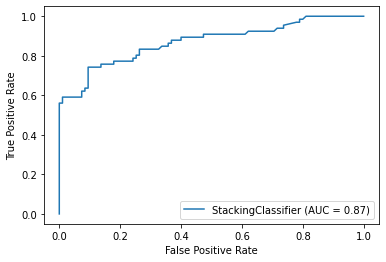

In [16]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(gscv2.best_estimator_, X_test2, y_test2)  
plt.show()

###Matriz de confusión###

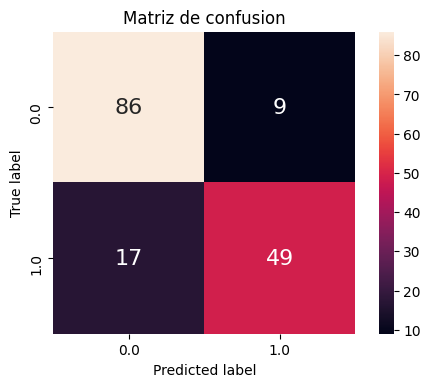

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test2, y_pred)

##Predicción##

In [18]:
X_holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
X = pp.scaler_ff_column_preprocessing(X_holdout)
prediction = pd.DataFrame(gscv2.predict(X),columns=['volveria'],dtype=int)
pred_formatted = pd.concat([X_holdout.id_usuario,prediction],axis=1)
pred_formatted.to_csv('stacking.csv')
pred_formatted

,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0
...,...,...
85,354,0
86,82,0
87,172,0
88,8,0
